# TP6 : Analysis and synthesis of bell sounds

Student : Thibault Lahire

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import scipy
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil

from scipy.io.wavfile import write

## 3 Synthetic signal

In [2]:
N = 63
f_0 = 0.25
f_1 = f_0 + 1/N
a_0 = 1
a_1 = 10
delta_0 = 0
delta_1 = -0.05

delta = np.array([delta_0, delta_1])
f = np.array([f_0, f_1])
a = np.array([a_0, a_1])

phi = np.random.uniform(-np.pi,np.pi, size=2)
print("Phases :", phi)
    
def Synthesis(N, delta, f, a, phi, RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b
    return s

x = Synthesis(N, delta, f, a, phi, RSB=False)

Phases : [-0.38212856  0.93820231]


In [3]:
def periodogram(x, zeropadding, title='Periodogram'):
    if not zeropadding:
        Xfft = np.fft.fft(x)
        periodo = np.append(Xfft, Xfft[0])
        ampli = np.abs(periodo)**2
        plt.plot(np.linspace(0, 1, len(ampli)), ampli)
        plt.title(title)
    else:
        x_pad = np.append(x, np.zeros(1024-N))
        Xfft_pad = np.fft.fft(x_pad)
        periodo_pad = np.append(Xfft_pad, Xfft_pad[0])
        ampli_pad = np.abs(periodo_pad)**2
        plt.plot(np.linspace(0, 1, len(ampli_pad)), ampli_pad)
        plt.title(title)

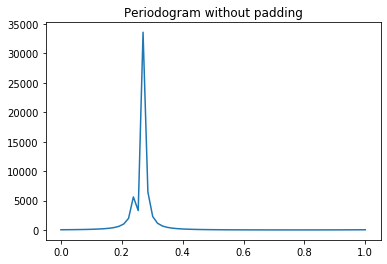

In [4]:
periodogram(x, False, 'Periodogram without padding')

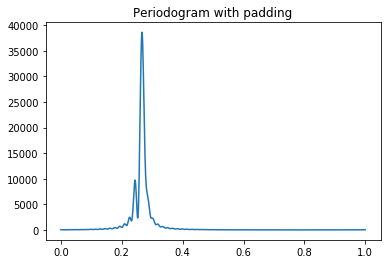

In [5]:
periodogram(x, True, 'Periodogram with padding')

The two pics are very difficult to distinguish, even if zero-padding helps a bit. Indeed, zero-padding allows us to have more points for the FFT, which means a higher accuracy in the spectral domain. However, even high-zero padding (1024) does not allow a clear discrimination of the two frequencies. 

In [6]:
def common_steps(x, n, l, K, N):
    X = scipy.linalg.hankel(x[:n],x[n-1:])
    R_xx_hat = (1/l)*X@X.conj().T
    U1, Lamb, U2 = np.linalg.svd(R_xx_hat)
    Lambda = np.diag(Lamb)
    W = U1[:,:K]
    W_orth = U1[:,K:]
    return W, W_orth

def least_squares(x, delta, f, N):
    t_vector = np.arange(N).reshape(1,-1).T
    val_vector = (delta + np.pi*f*2j).reshape(1,-1)
    ln_V_N = t_vector@val_vector
    V_N = np.exp(ln_V_N)
    alpha = np.linalg.pinv(V_N)@x
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

In cell below and the cell above, we did not follow exactly the TP handout and add more arguments to the functions esprit, music and least_squares to provide a clearer notebook.

In [7]:
def esprit(x, n, l, K, N):
    W, _ = common_steps(x, n, l, K, N)
    W_down = W[:-1]
    W_up = W[1:]
    phi = np.linalg.pinv(W_down)@W_up
    eigenvalues_of_phi, eigenvectors_of_phi = np.linalg.eig(phi)
    delta_new = np.log(np.abs(eigenvalues_of_phi))
    freq_new = np.angle(eigenvalues_of_phi)/(2*np.pi)
    a_new, phi_new = least_squares(x, delta_new, freq_new, N)
    return delta_new, freq_new, a_new, phi_new

def music(x, n, l, K, N):
    _, W_orth = common_steps(x, n, l, K, N)
    
    def P(z):
        v_n_z = z**(np.arange(n))
        return 1/np.linalg.norm((W_orth.conjugate().T)@v_n_z.T)**2
    
    X, Y = np.meshgrid(np.linspace(0.2,0.3,51),np.linspace(-0.1,0.1,51))
    Z = np.zeros_like(X)
    for i in range(0,len(X)):
        for j in range(0,len(X[0])):
            compl = np.exp(Y[i][0]+X[0][j]*np.pi*2j)
            Z[i][j] = np.log10(P(compl))
    graphe = plt.pcolormesh(X,Y,Z)
    plt.xlabel('frequencies')
    plt.ylabel('delta')
    plt.title('Pseudo-spectrum')

In [8]:
n = 32
K = 2
N = 63
l = N - n + 1
delta_ESPRIT, freq_ESPRIT, a_ESPRIT, phi_ESPRIT = esprit(x, n, l, K, N)
print("delta_ESPRIT =", delta_ESPRIT)
print("freq_ESPRIT =", freq_ESPRIT)
print("a_ESPRIT =", a_ESPRIT)
print("phi_ESPRIT =", phi_ESPRIT)

delta_ESPRIT = [-5.00000000e-02 -2.22044605e-16]
freq_ESPRIT = [0.26587302 0.25      ]
a_ESPRIT = [10.  1.]
phi_ESPRIT = [ 0.93820231 -0.38212856]


With the ESPRIT method, we perfectly recover the parameters we set at the beginning of the practical assignment, which was not possible with the Fourier transform.

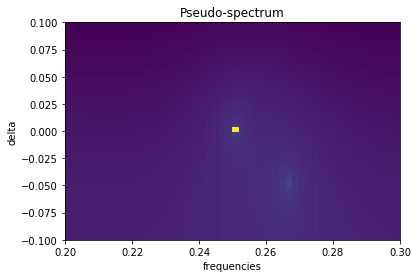

In [9]:
music(x, n, l, K, N)

With the MUSIC method, we see the damping factors and the frequencies on the pseudo-spectrum. The frequency at 0.25 is clearly visible, and the other one can be distinguished. Note that the "resonance" of frequency 0.25 on the pseudo-spectrum is much higher than the one of the other frequency, that's why the color are not similar.

## 4 Audio signals

Below some useful imports

In [10]:
def load_music(file):
    return wave.open(file, 'rb')


def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = wave.open(file, 'rb')
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

    
def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def write_file(data, Fs, name):
    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    write(name+'.wav', Fs, scaled)
    return name+'.wav'

def listen_file(filename):
    current_path = os.getcwd()
    data_path = os.path.join(current_path, 'Sons')
    music = os.path.join(data_path, filename)
    play_music(music)

Next function imported from TP1

In [11]:
def preprocess_sound(filename='clocheA.wav', plot=True):
    current_path = os.getcwd()
    data_path = os.path.join(current_path, 'Sons')
    music = os.path.join(data_path, filename)
    play_music(music)
    wavefile = load_music(music)
    Fs = int(wavefile.getframerate())
    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack('{n}h'.format(n=num_samples), data)
    x = np.array(data)
    timestep = 1/float(Fs)
    times = np.arange(len(x))*timestep       
    N = 1535 # Window size of analysed signal (only one window of signal is analysed)
    dF_min=Fs/N   # Minimal frequency resolution
    w=np.hamming(N)  # Window
    width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
    eps=float(1e-20)   #precision
    offset = 10000
    xw=x[offset:offset+N]*w    # xw is the analysed signal frame
    n_xw = xw.size
    #Minimal number of data points to satisfy the minimal frequency resolution
    Nfft_min=Fs/dF_min
    #compute the smallest power of two that satisfies the minimal frequency resolution for FFT
    p, Nfft = nextpow2(Nfft_min)
    x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
    x_fft /= np.max(np.abs(x_fft))+eps # Normalization
    df=Fs/Nfft # frequency virtual resolution of FFT 
    frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
    X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)
    if plot:
        plt.figure(figsize=(30, 4))
        plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
        plt.xlim(0, 1000)
        plt.ylim(-80, 0)
        plt.xlabel('Fréquences (Hz)')
        plt.ylabel('Spectre d\'Amplitude (dB)')
        plt.title('Spectre d\'amplitude du signal original')
        plt.show()
    return frequencies, X_fft, Nfft, width, dF_min, x, Fs

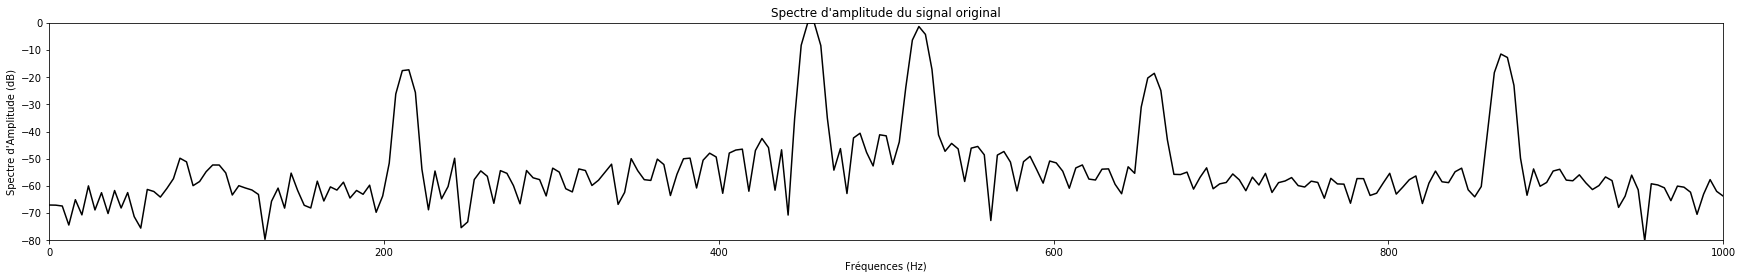

The width of a pic is about 20.8 Hz


In [12]:
frequencies, X_fft, Nfft, width, dF_min, x, Fs = preprocess_sound()
print("The width of a pic is about {:.3} Hz".format(width))

As explained in the TP handout, we observe on the figure hereinabove the bum (ratio 0.5), the prime (ratio 1), the minor third (ration 1.2), the fifth (ratio 1.5) and the octave (ratio 2).

In [13]:
K = 54
n = 512
l = 2*n
N = 1535
offset = 10000

x = x[offset:offset+N]

delta_ESPRIT, freq_ESPRIT, a_ESPRIT, phi_ESPRIT = esprit(x, n, l, K, N)
print("delta_ESPRIT =", delta_ESPRIT)
print("freq_ESPRIT =", freq_ESPRIT)
print("a_ESPRIT =", a_ESPRIT)
print("phi_ESPRIT =", phi_ESPRIT)

delta_ESPRIT = [-7.90939657e-05 -7.90939657e-05 -8.41152088e-04 -8.41152088e-04
 -4.13656028e-04 -4.13656028e-04 -1.98458138e-04 -1.98458138e-04
 -6.48153279e-04 -6.48153279e-04 -4.74427120e-04 -4.74427120e-04
 -3.09475983e-04 -3.09475983e-04 -4.51670321e-03 -4.51670321e-03
 -3.79745631e-04 -3.79745631e-04 -7.00056075e-05 -7.00056075e-05
 -9.65162227e-04 -9.65162227e-04  5.57542407e-04  5.57542407e-04
 -6.10417914e-04 -6.10417914e-04  1.28279157e-04  1.28279157e-04
 -3.39170059e-04 -3.39170059e-04  1.39098461e-04  1.39098461e-04
  9.37846149e-06  9.37846149e-06 -4.13540500e-05 -4.13540500e-05
 -1.23696144e-04 -1.23696144e-04  9.29162567e-05  9.29162567e-05
 -1.75234518e-04 -1.75234518e-04 -1.08880103e-04 -1.08880103e-04
 -4.81450430e-04 -4.81450430e-04 -1.19120697e-04 -1.19120697e-04
 -1.82033490e-03 -1.82033490e-03  4.80163328e-04  4.80163328e-04
 -5.71803628e-04 -5.71803628e-04]
freq_ESPRIT = [ 0.43121701 -0.43121701  0.42319682 -0.42319682  0.4070735  -0.4070735
  0.35880444 -0.3588

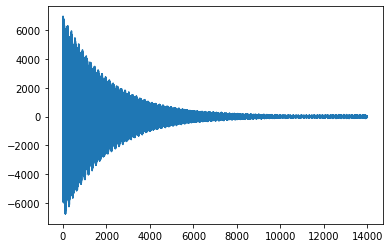

In [14]:
resynthese = Synthesis(14000, delta_ESPRIT, freq_ESPRIT, a_ESPRIT, phi_ESPRIT, RSB=False)
resynthese = np.flip(np.real(resynthese))
write_file(resynthese, Fs, 'Sons/resynthesis')
plt.plot(resynthese)
listen_file('resynthesis.wav')

The resynthesized excerpt sounds like a bell and highlights the sound resonances.